In [9]:
# monitor UART input on COM5
# create GUI button to start/stop data collection
# create GUI button to clear data

import serial
import time
#import msvcrt
import tkinter as tk
import threading
import queue 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

command = queue.Queue()
data = queue.Queue()

base_width = 800
base_height = 400

# create a GUI window
window = tk.Tk()
window.title("Serial Data Grapher / Logger")
window.geometry("{}x{}".format(base_width, base_height))

# create a button to start/stop data collection
def start_stop():
    if start_stop_button["text"] == "Start":
        start_stop_button["text"] = "Stop"
        command.put("start")
    else:
        start_stop_button["text"] = "Start"
        command.put("stop")

def getNumber(string):
    try:
        return int(string)
    except:
        try:
            return float(string)
        except:
            return None
        
plot_width = 300
plot_height = 300
padding = 0.25

def add_plot(word):
    num_rows = int(len(plots) / max_cols) + 1
    num_cols = min(max_cols, len(plots)+1)
    print("num_rows: " + str(num_rows) + " num_cols: " + str(num_cols))
    #gs = gridspec.GridSpec(num_rows, num_cols)
    #fig.set_figwidth(num_cols * figW)
    #fig.set_figheight(num_rows * figH)
    gs = gridspec.GridSpec(num_rows, num_cols)
    gs.update(hspace=0.5, wspace=0.25)  # Change these values to adjust spacing and padding

    row, col = divmod(len(plots), num_cols)
    print("row: " + str(row) + " col: " + str(col))
    plots[word] = {"len": 0}
    plots[word]["plot"] = fig.add_subplot(gs[row, col])
    plots[word]["plot"].set_title(word)
    plots[word]["plot"].set_xlabel('Time')
    plots[word]["plot"].set_ylabel('Value')

    # calculate size of canvas and set window geometry
    canvas_width = num_cols * plot_width + plot_width * (num_cols - 1) * padding
    canvas_height = num_rows * plot_height + plot_height * (num_rows - 1) * padding
    window.geometry("{}x{}".format(int(base_width+canvas_width), int(base_height+canvas_height)))

    for plot, i in zip(plots.values(), range(len(plots))):
        row, col = divmod(i, num_cols)
        plot["plot"].change_geometry(num_rows, num_cols, i+1)
        plot["plot"].set_position(gs[row, col].get_position(fig))
        plot["plot"].set_subplotspec(gs[row, col])

terminals = {}

def newTerminal(name):
    terminals[name] = {}
    terminals[name]["frame"] = tk.Frame(terminals_frame)
    # space all terminals evenly
    #terminals[name]["frame"].grid(row=0, column=len(terminals))
    #terminals[name]["frame"].grid_columnconfigure(len(terminals), weight=1, uniform="terminals")
    #terminals[name]["frame"].grid(row=0, column=len(terminals), sticky="nsew")
    terminals[name]["scrollbar"] = tk.Scrollbar(terminals[name]["frame"])
    terminals[name]["scrollbar"].pack(side=tk.RIGHT, fill=tk.Y)
    terminals[name]["terminal"] = tk.Text(terminals[name]["frame"], height=10, width=40, yscrollcommand=terminals[name]["scrollbar"].set)
    terminals[name]["terminal"].pack(side=tk.LEFT, fill=tk.BOTH, expand=True)
    terminals[name]["scrollbar"].config(command=terminals[name]["terminal"].yview)
    terminals[name]["frame"].pack(side=tk.LEFT, fill=tk.BOTH, expand=True, padx=10, pady=10)
    # if only one terminal, expand to fill window
    terminals[name]["frame"].pack_propagate(True if len(terminals) == 1 else False)

    # configure terminal frames to resize evenly
    # for i in range(len(terminals)):
    #     terminals_frame.grid_columnconfigure(i, weight=1, uniform="terminals")
    # for i, terminal in enumerate(terminals.values()):
    #     terminal["frame"].grid_columnconfigure(i, weight=1, uniform="terminals")

def logToTerminal(terminalName, message):
    if terminalName not in terminals:
        newTerminal(terminalName)
    terminal = terminals[terminalName]["terminal"]
    terminal.insert(tk.END, message)
    terminal.see(min(tk.END, terminal.index("end-1c")))

def data_callback():
    global points
    if not data.empty():
        message: str = data.get()
        #print('callback got', message)
        #terminal.insert(tk.END, message)
        #terminal.see(min(tk.END, terminal.index("end-1c")))
        if len(message.split()) == 2:
            word, value = message.split()
            if points % 20 == 0 and send_test_messages.get():
                word = word + str(points // 20)
            value = getNumber(value)
            if word.isalnum() and value is not None:
                #print("Plotting! " + word + " " + value)
                if word not in plots:
                    add_plot(word)
                    newTerminal(word)

                logToTerminal(word, message)
                #plots[word]["plot"].plot(time.time(), value, 'bo')
                plots[word]["len"] += 1
                plots[word]["plot"].plot(plots[word]["len"], value, 'bo')
                points+=1

                canvas.draw()
            else:
                logToTerminal("main", message)
        elif message.lower().startswith("error"):
            start_stop_button["text"] = "Start"
            logToTerminal("main", message)
            #command.put("stop")
    window.after(10, data_callback)

def serialPoll():
    ser = serial.Serial(None, 9600, timeout=0.1)
    #ser.flush()
    last_send = time.time()

    while (True):
        if not command.empty():
                cmd = command.get()
                if cmd == "start" and not ser.isOpen():
                    ser.port = serial_port.get()
                    print("opening serial port: " + ser.port)
                    try:
                        ser.open()
                    except:
                        data.put("error opening serial port: " + ser.port + "\r\n")
                elif cmd == "stop":
                    ser.close()
                elif cmd == "quit":
                    ser.close()
                    break
                else:
                    print("unknown command: " + cmd)
    
        if ser.isOpen():
            if ser.in_waiting > 0:
                line = ser.readline().decode('utf-8').rstrip()
                #print(line)
                data.put(line+"\r\n")
                if save_to_file.get():
                    print("saving to file!")
                    f = open("TTL.txt", "a")
                    f.write(line)  
                    f.close()
            #print(time.time())
            # else:
            #     time.sleep(0.1)
            # send a character to the serial port if time since last send is > 1 second
            if send_test_messages.get() and time.time() - last_send > 0.1:
                #print("sending 2")
                ser.write(b'helloWorld ' + str.encode(str(time.time())))
                last_send = time.time()
        else:
            time.sleep(0.1) # pause so we don't eat up CPU cycles (CPU usage spikes without this)

    #window.after(100, serialPoll)

#window.after(100, serialPoll)
thread = threading.Thread(target=serialPoll, daemon=True)
thread.start()

plots = {}
points = 1

max_cols = 3  # Change this to the number of columns you want

# num_cols = min(max_cols, len(plots))
# num_rows = int(len(plots) / max_cols) + 1
# gs = gridspec.GridSpec(num_rows, num_cols)
# gs.update(hspace=0.5, wspace=0.5)  # Change these values to adjust spacing and padding

buttonFrame = tk.Frame(window)
buttonFrame.pack(side=tk.TOP, padx=5, pady=5)

start_stop_button = tk.Button(buttonFrame, text="Start", command=start_stop)
start_stop_button.pack(side=tk.LEFT, padx=5, pady=5)

# small text box to the right of the start/stop button to enter the serial port
serial_port = tk.StringVar(value="COM5")
tk.Label(buttonFrame, text="Port:").pack(side=tk.LEFT, padx=5, pady=5)
port_entry = tk.Entry(buttonFrame, width=10, textvariable=serial_port)
port_entry.pack(side=tk.LEFT, padx=5, pady=5)

# create a button to clear data
def clear():
    global plots, points, fig, terminals
    #terminal.delete(1.0, tk.END)
    # delete all terminals except main
    for terminal in terminals:
        if terminal != "main":
            terminals[terminal]["frame"].destroy()
            #del terminals[terminal]
    terminals = {"main": terminals["main"]}

    plots = {}
    # clear the figure
    fig.clf()
    # reset size of window
    window.geometry("{}x{}".format(base_width, base_height))
    points = 1
    canvas.draw()
    
clear_button = tk.Button(buttonFrame, text="Clear", command=clear)
clear_button.pack(side=tk.LEFT, padx=5, pady=5)

# create a checkbox to enable/disable save to file
save_to_file = tk.BooleanVar()
#save_to_file = False
save_to_file_checkbox = tk.Checkbutton(buttonFrame, text="Save to file", variable=save_to_file)
save_to_file_checkbox.pack(side=tk.LEFT, padx=5, pady=5)

# create a checkbox to send test messages
send_test_messages = tk.BooleanVar()
#send_test_messages = False
send_test_messages_checkbox = tk.Checkbutton(buttonFrame, text="Send test messages", variable=send_test_messages)
send_test_messages_checkbox.pack(side=tk.LEFT, padx=5, pady=5)

# create a terminal window that will display the data
terminals_frame = tk.Frame(window)
#terminals_frame.grid()
terminals_frame.pack(side=tk.BOTTOM, fill=tk.BOTH, expand=True, padx=10, pady=10)


# terminal_scrollbar = tk.Scrollbar(terminal_frame)
# terminal_scrollbar.pack(side=tk.RIGHT, fill=tk.Y)

# terminal = tk.Text(terminal_frame, height=10, width=80, yscrollcommand=terminal_scrollbar.set)
# terminal.pack(side=tk.LEFT, fill=tk.BOTH, expand=True)

# terminal_scrollbar.config(command=terminal.yview)

newTerminal("main")

figW = 5
figH = 4
fig = plt.Figure(figsize=(figW, figH), dpi=100)
fig.tight_layout()
canvas = FigureCanvasTkAgg(fig, master=window)
canvas.draw()
canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=1)

window.after(10, data_callback)

# start the GUI window
window.mainloop()

command.put("quit")

# pause for 1 second
time.sleep(0.2)

Exception ignored in: <function Variable.__del__ at 0x00000192B141E940>
Traceback (most recent call last):
  File "c:\Program Files\Python39\lib\tkinter\__init__.py", line 363, in __del__
    if self._tk.getboolean(self._tk.call("info", "exists", self._name)):
RuntimeError: main thread is not in main loop


In [79]:
testword = "test_1"

def is_float(value):
  if value is None:
      return False
  try:
      float(value)
      return True
  except:
      return False

#print(is_float(testword))
#print(float(testword))
#print(int(testword))
#print(getNumber(testword))
print(testword.isalnum())

False


5
Total number of plotted values: 5


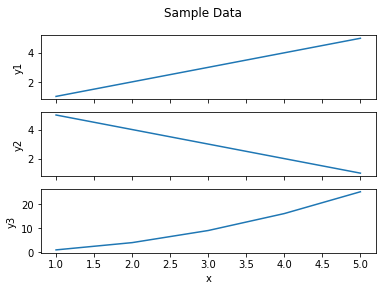

In [114]:
# create a figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)

# graph sample data
ax1.plot([1, 2, 3, 4, 5], [1, 2, 3, 4, 5])
ax2.plot([1, 2, 3, 4, 5], [5, 4, 3, 2, 1])
ax3.plot([1, 2, 3, 4, 5], [1, 4, 9, 16, 25])

# print the x axis
#print(len(ax1.lines))

# get the number of plotted values
total_points = 0
for line in ax1.lines:
    xydata = line.get_xydata()
    num_points = len(xydata)
    print (len(xydata))
    total_points += num_points

print("Total number of plotted values:", total_points)

# set the x axis label
ax3.set_xlabel("x")

# set the y axis labels
ax1.set_ylabel("y1")
ax2.set_ylabel("y2")
ax3.set_ylabel("y3")

# set the title
fig.suptitle("Sample Data")

# show the plot
plt.show()


In [93]:
#ax4 = fig.add_subplot(111, projection='3d')
ax4 = fig.add_subplot(111)
ax4.set_xlabel("label1")
ax4.set_ylabel("label2")

ax4.plot([1, 2, 3, 4, 5], [1, 2, 3, 4, 5], [1, 4, 9, 16, 25])

plt.show()

In [7]:
len(terminals)

3